In [109]:
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
import calendar
import cartopy.crs as ccrs
import netCDF4 as nc
import pandas as pd
import matplotlib.dates as mdates
import glob
import requests
import io

Import dataset and reconstruct it to gridded dataset of time, lat, lon

In [2]:
nc2020 = nc.Dataset("gfed_data/GFED4.1s_2020_beta.hdf5")

In [3]:
nc2020.groups['emissions'].groups['01'].variables['C']

<class 'netCDF4._netCDF4.Variable'>
float32 C(phony_dim_8, phony_dim_9)
    long_name: GFED4s biomass burning carbon emissions
    units: g C / m^2 / month
path = /emissions/01
unlimited dimensions: 
current shape = (720, 1440)
filling off

In [4]:
lat_array = np.array(nc2020.variables['lat'])[:, 0]
lon_array = np.array(nc2020.variables['lon'])[0, :]
time_2020 = np.arange('2020-01-01', '2020-11-1', dtype='datetime64[D]')

Using daily fraction, split monthly emission into daily emission

In [5]:
year = 2020
C_2020 = None
for month in range(1, 11):
    nc_2020_mo = nc2020.groups['emissions'][str(month).zfill(2)]
    nc_2020_mo_C = np.array(nc_2020_mo.variables['C'])
    last_day = calendar.monthrange(year,month)[1]
    daily_fraction = np.empty((last_day,) + nc_2020_mo_C.shape)
    for day in range(1, last_day+1):
        daily_fraction[day-1,:,:] = np.array(nc_2020_mo.groups['daily_fraction'].variables['day_'+str(day)])
    month_C = nc_2020_mo_C * daily_fraction
    if C_2020 is None:
        C_2020 = month_C
    else:
        C_2020 = np.concatenate((C_2020, month_C), axis=0)

Check if the shape of the dataset is (time, lat, lon)

In [6]:
C_2020.shape

(305, 720, 1440)

Construct dataset with three coordinates

In [7]:
C_emission_2020 = xr.Dataset(
    {
        "carbon_emission": (["time", "lat", "lon"], C_2020),
    },
    coords={
        "time": time_2020,
        "lat": lat_array,
        "lon": lon_array,
    },
)

Create animation of 2020 California Wildfire

In [56]:
x1, x2, y1, y2 = (-127.5, -110, 50, 32.5)
grid_step = 2.5

In [9]:
dr = C_emission_2020['carbon_emission']
print(dr.loc[:, y1:y2, x1:x2].max().item())

1824.1071115182422


In [10]:
cmax = 1900
levels = np.linspace(0, 1800, 10)

In [99]:
daterange = np.arange('2020-08-01', '2020-10-10', dtype='datetime64[D]')
artists = []
for date in daterange:
    fig = plt.figure(figsize=[12, 12])
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(color='white')
    ax.gridlines(linestyle='--')
    ax.set_extent((x1, x2, y1, y2))
    ax.set_title('surface carbon emission')
    dr = C_emission_2020['carbon_emission'].sel(time=date)
    dr.plot(ax=ax, vmin=0, vmax=cmax, 
            cmap=plt.get_cmap('hot'), cbar_kwargs={'shrink': 0.8, 'ticks': levels,
                                                   'spacing': 'proportional', 'label': '$g-C / m^2$'})
    plt.savefig("anim/{date}.png".format(date=date), dpi=150)
    plt.close()

Animation in `anim` directory.

Regridding by 2.5x2.5

In [11]:
xx = np.arange(x1, x2, grid_step)
yy = np.arange(y1, y2, -grid_step)
xx, yy

(array([-127.5, -125. , -122.5, -120. , -117.5, -115. , -112.5]),
 array([50. , 47.5, 45. , 42.5, 40. , 37.5, 35. ]))

In [12]:
dr.coords

Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-10-31
  * lat      (lat) float32 89.875 89.625 89.375 ... -89.375 -89.625 -89.875
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875

In [14]:
# lat, lon, time
agg_data = np.empty((len(yy), len(xx), len(time_2020)))

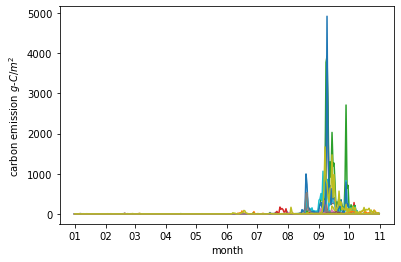

In [15]:
fig, ax = plt.subplots()
for i, y in enumerate(yy):
    for j, x in enumerate(xx):
        agg_data[i][j] = dr.loc[:, y:y-grid_step, x:x+grid_step].sum(dim=['lat', 'lon'])
        ax.plot(time_2020, agg_data[i][j], label=(i,j))
myFmt = mdates.DateFormatter('%m')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('month')
ax.set_ylabel('carbon emission $g$-$C / m^2$')
plt.show()

Find when the fire is happening

In [16]:
start_end_idx = [[None for _ in range(len(agg_data))] for _ in range(len(agg_data))]

In [17]:
for i in range(len(yy)):
    for j in range(len(xx)):
        arr = agg_data[i][j]
        diff_arr = np.diff(np.sign(arr))
        end_idx = np.where(diff_arr==-1)[0]
        start_idx = np.where(diff_arr==1)[0]+1
        if len(start_idx) != 0 and len(end_idx) != 0:
            if end_idx[0] < start_idx[0]:
                end_idx = end_idx[1:]
            if start_idx[-1] > end_idx[-1]:
                start_idx = start_idx[:-1]
            start_end_idx[i][j] = np.dstack((start_idx, end_idx)).reshape((-1, 2))

In [43]:
term_limit = (datetime.datetime(2020, 11, 1) - datetime.datetime(2020, 1, 1)).days

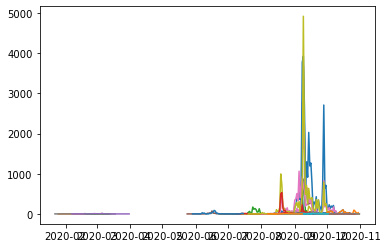

In [44]:
for i in range(len(yy)):
    for j in range(len(xx)):
        arr = start_end_idx[i][j]
        if arr is not None:
            duration = arr[:, 1] - arr[:, 0]
            terms = arr[duration > 7]
            for term in terms:
                term_duration = term[1] - term[0]
                term_s = term[0] - term_duration
                term_s = term_s if term_s >= 0 else 0
                term_e = term[1] + term_duration
                term_e = term_e if term_e <= term_limit else term_limit
                gy1 = yy[i]
                gy2 = gy1 - grid_step
                gx1 = xx[j]
                gx2 = gx1 + grid_step
                start_date = datetime.datetime(2020, 1, 1) + datetime.timedelta(days=int(term_s))
                end_date = datetime.datetime(2020, 1, 1) + datetime.timedelta(days=int(term_e))
                daterange = np.arange(start_date, end_date, dtype='datetime64[D]')
                emission = agg_data[i, j, term_s:term_e]
                d = {'date': daterange, 
                     'x1': [gx1 for _ in range(len(emission))], 
                     'x2': [gx2 for _ in range(len(emission))], 
                     'y1': [gy1 for _ in range(len(emission))], 
                     'y2': [gy2 for _ in range(len(emission))], 
                     'emission': emission}
                pd.DataFrame(data=d).to_csv("gfed_fire_term/{x1}-{x2}_{y1}-{y2}_{term_s}-{term_e}.csv".format(x1=gx1, x2=gx2, y1=gy1, y2=gy2, term_s=term_s, term_e=term_e))

In [164]:
gfed_list = glob.glob('gfed_fire_term/*')

In [165]:
df1 = pd.read_csv(gfed_list[0], index_col=[0], parse_dates=['date'])
df1.head()

,date,x1,x2,y1,y2,emission
0,2020-07-07,-122.5,-120.0,42.5,40.0,0.0
1,2020-07-08,-122.5,-120.0,42.5,40.0,0.0
2,2020-07-09,-122.5,-120.0,42.5,40.0,0.0
3,2020-07-10,-122.5,-120.0,42.5,40.0,0.0
4,2020-07-11,-122.5,-120.0,42.5,40.0,0.0


Getting Ozone data based on the GFED grid - OpenAQ API [here](https://docs.openaq.org/).

In [45]:
get_measurement_url = "https://api.openaq.org/v1/measurements"

In [104]:
lon = df1.iloc[0]['x1'] + grid_step / 2
lat = df1.iloc[0]['y1'] - grid_step / 2
from_date = df1.date.min().date()
to_date = df1.date.max().date()
print(lat, lon, from_date, to_date)
print(str(lat) + "," + str(lon))

41.25 -121.25 2020-07-07 2020-08-11
41.25,-121.25


In [105]:
measurement_param = {
    'parameter': 'o3',
    'has_geo': True,
    'coordinates': str(lat) + "," + str(lon),
    'radius': grid_step / 2 * 111000,
    'date_from': str(from_date),
    'date_to': str(to_date),
    'limit': 10000,
    'format': 'csv'
}

In [106]:
measure_response = requests.get(get_measurement_url, params=measurement_param)

In [110]:
o3_df1 = pd.read_csv(io.BytesIO(measure_response.content), sep=",", parse_dates=["utc", "local"])

In [155]:
mean_df1 = o3_df1.groupby([pd.Grouper(key="utc", freq="D")]).agg({'value': lambda x: x.mean(skipna=True)})
mean_df1.head()

,value
utc,
2020-07-07 00:00:00+00:00,0.036727
2020-07-08 00:00:00+00:00,0.033783
2020-07-09 00:00:00+00:00,0.034714
2020-07-10 00:00:00+00:00,0.030257
2020-07-11 00:00:00+00:00,0.038224


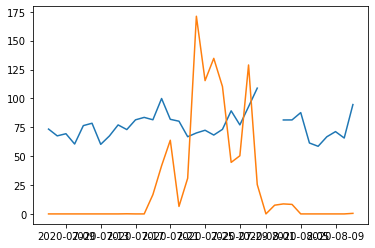

In [154]:
plt.plot(mean_df1.value * 2000)
plt.plot(df1.date, df1.emission)

Mass Production

In [158]:
from os import path

In [169]:
for gfed_path in gfed_list:
    gfed_df = pd.read_csv(gfed_path, index_col=[0], parse_dates=['date'])
    lon = gfed_df.iloc[0]['x1'] + grid_step / 2
    lat = gfed_df.iloc[0]['y1'] - grid_step / 2
    from_date = gfed_df.date.min().date()
    to_date = gfed_df.date.max().date()
    print("parameters:", gfed_df.iloc[0]['y1'], gfed_df.iloc[0]['x1'], from_date, to_date)
    measurement_param = {
        'parameter': 'o3',
        'has_geo': True,
        'coordinates': str(lat) + "," + str(lon),
        'radius': grid_step / 2 * 111000,
        'date_from': str(from_date),
        'date_to': str(to_date),
        'limit': 10000,
        'format': 'csv'
    }
    measure_response = requests.get(get_measurement_url, params=measurement_param)
    print(measure_response)
    o3_df = pd.read_csv(io.BytesIO(measure_response.content), sep=",", parse_dates=["utc", "local"])
    print(len(o3_df))
    if o3_df.empty:
        continue
    else:
        mean_df = o3_df.groupby([pd.Grouper(key="utc", freq="D")]).agg({'value': lambda x: x.mean(skipna=True)})
        mean_df.to_csv("openAQ_term/{filename}".format(filename=path.basename(gfed_path)))

parameters: 42.5 -122.5 2020-07-07 2020-08-11
<Response [200]>
3587
parameters: 40.0 -122.5 2020-06-23 2020-10-31
<Response [200]>
10000
parameters: 37.5 -122.5 2020-07-09 2020-10-27
<Response [200]>
10000
parameters: 47.5 -117.5 2020-08-15 2020-10-04
<Response [200]>
717
parameters: 40.0 -122.5 2020-01-22 2020-03-18
<Response [200]>
10000
parameters: 35.0 -117.5 2020-08-22 2020-10-02
<Response [200]>
10000
parameters: 47.5 -115.0 2020-08-31 2020-09-26
<Response [200]>
481
parameters: 35.0 -117.5 2020-07-20 2020-08-15
<Response [200]>
10000
parameters: 47.5 -122.5 2020-08-12 2020-09-16
<Response [200]>
3868
parameters: 40.0 -125.0 2020-06-24 2020-10-31
<Response [200]>
7141
parameters: 40.0 -120.0 2020-10-01 2020-10-30
<Response [200]>
6347
parameters: 45.0 -112.5 2020-09-16 2020-10-21
<Response [200]>
1559
parameters: 45.0 -125.0 2020-08-29 2020-09-27
<Response [200]>
1646
parameters: 42.5 -125.0 2020-06-28 2020-10-31
<Response [200]>
8569
parameters: 50.0 -117.5 2020-08-26 2020-09-21

EmptyDataError: No columns to parse from file

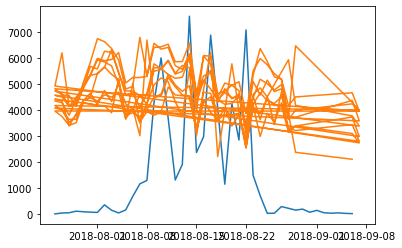

In [174]:
plt.plot(time_2018[206:249], agg_data[1][0][206:249])
df_select = mean_df.loc[pd.IndexSlice[:, time_2018[206]:time_2018[249]],:]
plt.plot(df_select.index.get_level_values("utc"), df_select.value*100000)

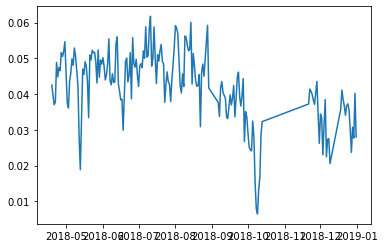

In [112]:
plt.plot(mean_df.loc[("Aspen Park",)]['value'])

Sample interpolation

In [72]:
example_row = o3.iloc[0]
example_row.utc.date()

datetime.date(2018, 10, 13)

In [88]:
dr_C = C_emission_2018['carbon_emission']
dr_C.interp(lat=example_row.latitude, lon=example_row.longitude)

<xarray.DataArray 'carbon_emission' (time: 365)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
    lat      float64 39.74
    lon      float64 -105.2